In [2]:
import os
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from random import choice
from tqdm.notebook import tqdm
from kaggle_environments import evaluate, make, utils
import datetime
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


Loading environment lux_ai_2022 failed: No module named 'vec_noise'


In [3]:
class ConnectX(gym.Env):
    def __init__(self, switch_prob=0.5):
        self.env = make('connectx', debug=True)
        self.pair = [None, 'negamax']
        self.trainer = self.env.train(self.pair)
        self.switch_prob = switch_prob

        # Define required gym fields (examples):
        config = self.env.configuration
        self.action_space = gym.spaces.Discrete(config.columns)
        self.observation_space = gym.spaces.Discrete(
            config.columns * config.rows)

    def switch_trainer(self):
        self.pair = self.pair[::-1]
        self.trainer = self.env.train(self.pair)

    def step(self, action):
        return self.trainer.step(action)

    def reset(self): # 有switch_prob的几率更换先手顺序
        if random.uniform(0, 1) < self.switch_prob:
            self.switch_trainer()
        return self.trainer.reset()

    def render(self, **kwargs):
        return self.env.render(**kwargs)


class QTable:
    def __init__(self, action_space):
        self.table = dict()
        self.action_space = action_space
        
    def add_item(self, state_key):
        self.table[state_key] = list(np.zeros(self.action_space.n))
        
    def __call__(self, state):
        board = state['board'][:]  # Get a copy
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        state_key = hex(int(''.join(state_key), 3))[2:]
        if state_key not in self.table.keys():
            self.add_item(state_key)
        
        return self.table[state_key]


In [4]:
env = ConnectX()


In [5]:
alpha = 0.1				    # 学习率
gamma = 0.6				    # discount factor γ
epsilon = 0.5				# ε-greedy策略的ε
min_epsilon = 0.1			# 最小ε

episodes = 20000			# 采样轮数

alpha_decay_step = 1000
alpha_decay_rate = 0.9		# α衰减率
epsilon_decay_rate = 0.9999	# ε衰减率

q_table = QTable(env.action_space)


In [6]:

all_epochs = []
all_total_rewards = []
all_avg_rewards = [] # Last 100 steps
all_qtable_rows = []
all_epsilons = []

for i in tqdm(range(episodes)):
    state = env.reset()     # 清空棋盘
    epochs,total_rewards = 0, 0
    epsilon = max(min_epsilon,epsilon*epsilon_decay_rate)   # ε每轮衰减
    done = False

    while not done :    # 开始一轮采样
        space_list = [c for c in range(env.action_space.n) if state['board'][c] == 0]

        if random.uniform(0,1) <= epsilon :# ε-greedy-->选择随机策略
            action = choice(space_list)
        else : # ε-greedy-->选择贪心策略
            row = np.array(q_table(state)[:])
            row[[c for c in range(env.action_space.n)
                 if state['board'][c] != 0]] = -1
            action = int(np.argmax(row))
        
        next_state,reward,done,info = env.step(action)

        if done:
            if reward == 1: # Won
                reward = 20
            elif reward == 0: # Lost
                reward = -20
            else: 
                reward = 1 # draw
        else:
            reward = -0.05

        old_value = q_table(state)[action]
        next_max = np.max(q_table(next_state))

        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table(state)[action] = new_value

        state = next_state
        epochs += 1
        total_rewards += reward

    all_epochs.append(epochs)
    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)
    all_qtable_rows.append(len(q_table.table))
    all_epsilons.append(epsilon)

    if (i+1) % alpha_decay_step == 0:
        alpha *= alpha_decay_rate



  0%|          | 0/20000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
def mysave(list,name):
    q = np.array(list)
    np.save(name + '.npy',q)

def myload(name):
    p = np.load(name + '.npy')
    return p.tolist()

In [ ]:
#保存Q表
mysave(q_table.table,'qtable')
#保存相关训练结果
mysave(all_epochs,'all_epochs')
mysave(all_total_rewards,'all_total_rewards')
mysave(all_avg_rewards,'all_avg_rewards')
mysave(all_qtable_rows,'all_qtable_rows')
mysave(all_epsilons,'all_epsilons')

In [8]:
#加载相关训练结果
all_epochs = myload('all_epochs')
all_total_rewards = myload('all_total_rewards')
all_avg_rewards = myload('all_avg_rewards')
all_qtable_rows = myload('all_qtable_rows')
all_epsilons = myload('all_epsilons')


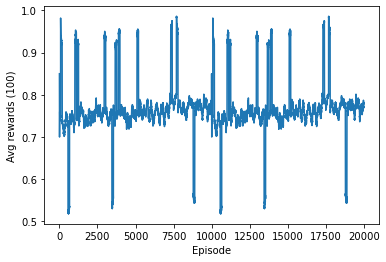

In [ ]:
plt.plot(all_avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Avg rewards (100)')
plt.show()


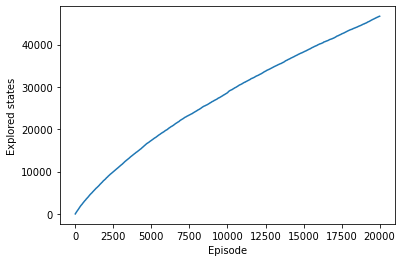

In [ ]:
plt.plot(all_qtable_rows)
plt.xlabel('Episode')
plt.ylabel('Explored states')
plt.show()


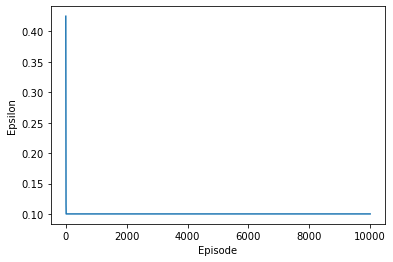

In [ ]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()


In [ ]:
tmp_dict_q_table = q_table.table.copy()
dict_q_table = dict()

for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))
        

In [ ]:
my_agent = '''def my_agent(observation, configuration):
    from random import choice

    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''

    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]

    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    action = q_table[state_key]

    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

    return action
    '''
    
with open('submission.py', 'w') as f:
    f.write(my_agent)

In [9]:
from submission import my_agent

def mean_reward(rewards):
    win = sum(1 if r[0]>0 else 0 for r in rewards)
    loss = sum(1 if r[1]>0 else 0 for r in rewards)
    draw = sum(1 if r[0] == r[1] else 0 for r in rewards)
    return '{0} episodes- won: {1} | loss: {2} | draw: {3} | winning rate: {4}%'.format(
        len(rewards),
        win,
        loss,
        draw,
        (win / len(rewards))*100
    )


# Run multiple episodes to estimate agent's performance.
print("My Agent vs Random Agent:", mean_reward(
    evaluate("connectx", [my_agent, "random"], num_episodes=100)))
print("My Agent vs Negamax Agent:", mean_reward(
    evaluate("connectx", [my_agent, "negamax"], num_episodes=100)))


My Agent vs Random Agent: 100 episodes- won: 61 | loss: 39 | draw: 0 | winning rate: 61.0%
My Agent vs Negamax Agent: 100 episodes- won: 6 | loss: 94 | draw: 0 | winning rate: 6.0%
